In [ ]:
# Setup: imports, config, reproducibility
import os, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# Load dataset
DATA_PATH = "/content/dataset.csv"
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

# Normalize column names to snake_case for consistency
def to_snake(s: str) -> str:
    return (
        s.strip()
         .replace(" ", "_")
         .replace("-", "_")
         .replace(".", "")
         .lower()
    )
df.columns = [to_snake(c) for c in df.columns]

# Identify target column 
possible_targets = ["price_range", "price", "target", "label"]
target = next((t for t in possible_targets if t in df.columns), None)
assert target is not None, f"Target column not found. Columns available: {list(df.columns)}"

#Basic dataset report 
n_rows, n_cols = df.shape
print(f"Shape: {n_rows} rows x {n_cols} columns")
print(f"Target column: '{target}'")

print("\nFirst 5 rows:")
display(df.head())

print("\nDtypes:")
print(df.dtypes)

# Missing values and duplicates
missing = df.isna().sum()
print("\nMissing values per column (non-zero only):")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values detected.")

dup_count = df.duplicated().sum()
print(f"\nDuplicate rows: {dup_count}")

# Target distribution
print("\nTarget value counts:")
if pd.api.types.is_numeric_dtype(df[target]):
    print(df[target].value_counts().sort_index())
else:
    print(df[target].astype(str).value_counts())

# Quick sanity checks for expected feature set
expected_cols = [
    "battery_power","blue","clock_speed","dual_sim","fc","four_g","int_memory","m_deep",
    "mobile_wt","n_cores","pc","px_height","px_width","ram","sc_h","sc_w","talk_time",
    "three_g","touch_screen","wifi"
]
present = [c for c in expected_cols if c in df.columns]
missing_expected = [c for c in expected_cols if c not in df.columns]
print(f"\nExpected feature columns found: {len(present)}/{len(expected_cols)}")
if missing_expected:
    print("Missing expected columns:", missing_expected)

# Sanity check labels
if pd.api.types.is_numeric_dtype(df[target]):
    unique_labels = sorted(df[target].dropna().unique().tolist())
    print("\nUnique target labels:", unique_labels)
    if not set(unique_labels).issubset({0, 1, 2, 3}):
        print("Note: Unexpected labels detected; we will map them later if needed.")

# Cache feature list for later steps
FEATURES = [c for c in df.columns if c != target]
print(f"\nTotal features: {len(FEATURES)}")

Shape: 2000 rows x 21 columns
Target column: 'price_range'

First 5 rows:


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1



Dtypes:
battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

Missing values per column (non-zero only):
No missing values detected.

Duplicate rows: 0

Target value counts:
price_range
0    500
1    500
2    500
3    500
Name: count, dtype: int64

Expected feature columns found: 19/20
Missing expected columns: ['m_deep']

Unique target labels: [0, 1, 2, 3]

Total features: 20


In [ ]:
# Split into train/validation/test with stratification
from sklearn.model_selection import train_test_split

# Features and target
X = df[FEATURES]
y = df[target]

# First split: train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=SEED
)

# Second split: validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=SEED
)

# Sanity checks
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("\nTarget distribution per split:")
for split_name, split_y in zip(
    ["Train", "Validation", "Test"],
    [y_train, y_val, y_test]
):
    print(f"{split_name}:\n{split_y.value_counts(normalize=True).sort_index()}")

# Save splits for later stages in Colab environment
X_train.to_csv("/content/X_train.csv", index=False)
X_val.to_csv("/content/X_val.csv", index=False)
X_test.to_csv("/content/X_test.csv", index=False)
y_train.to_csv("/content/y_train.csv", index=False)
y_val.to_csv("/content/y_val.csv", index=False)
y_test.to_csv("/content/y_test.csv", index=False)

Train: (1400, 20), Val: (300, 20), Test: (300, 20)

Target distribution per split:
Train:
price_range
0    0.25
1    0.25
2    0.25
3    0.25
Name: proportion, dtype: float64
Validation:
price_range
0    0.25
1    0.25
2    0.25
3    0.25
Name: proportion, dtype: float64
Test:
price_range
0    0.25
1    0.25
2    0.25
3    0.25
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
battery_power,1400.0,1237.027143,440.555073,502.0,842.00,1222.5,1615.0,1998.0
blue,1400.0,0.499286,0.500178,0.0,0.00,0.0,1.0,1.0
clock_speed,1400.0,1.526071,0.824300,0.5,0.70,1.5,2.3,3.0
dual_sim,1400.0,0.505714,0.500146,0.0,0.00,1.0,1.0,1.0
fc,1400.0,4.215000,4.251417,0.0,1.00,3.0,7.0,18.0
four_g,1400.0,0.515714,0.499932,0.0,0.00,1.0,1.0,1.0
int_memory,1400.0,32.147143,18.209559,2.0,16.00,31.0,48.0,64.0
m_dep,1400.0,0.505143,0.290107,0.1,0.20,0.5,0.8,1.0
mobile_wt,1400.0,140.125714,35.361221,80.0,109.00,141.0,170.0,200.0
n_cores,1400.0,4.564286,2.279946,1.0,3.00,5.0,7.0,8.0


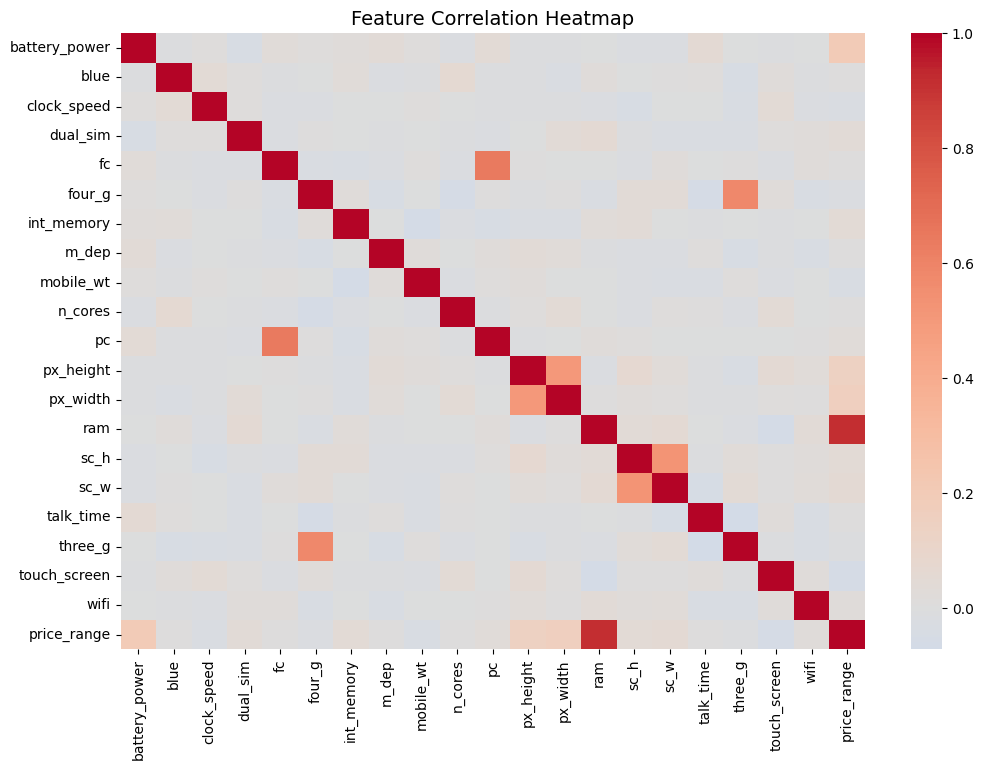

Top correlations with target:
 ram              0.918128
battery_power    0.199775
px_width         0.162237
px_height        0.142968
touch_screen    -0.055584
sc_w             0.050386
int_memory       0.045100
sc_h             0.043936
mobile_wt       -0.036183
dual_sim         0.033224
Name: price_range, dtype: float64


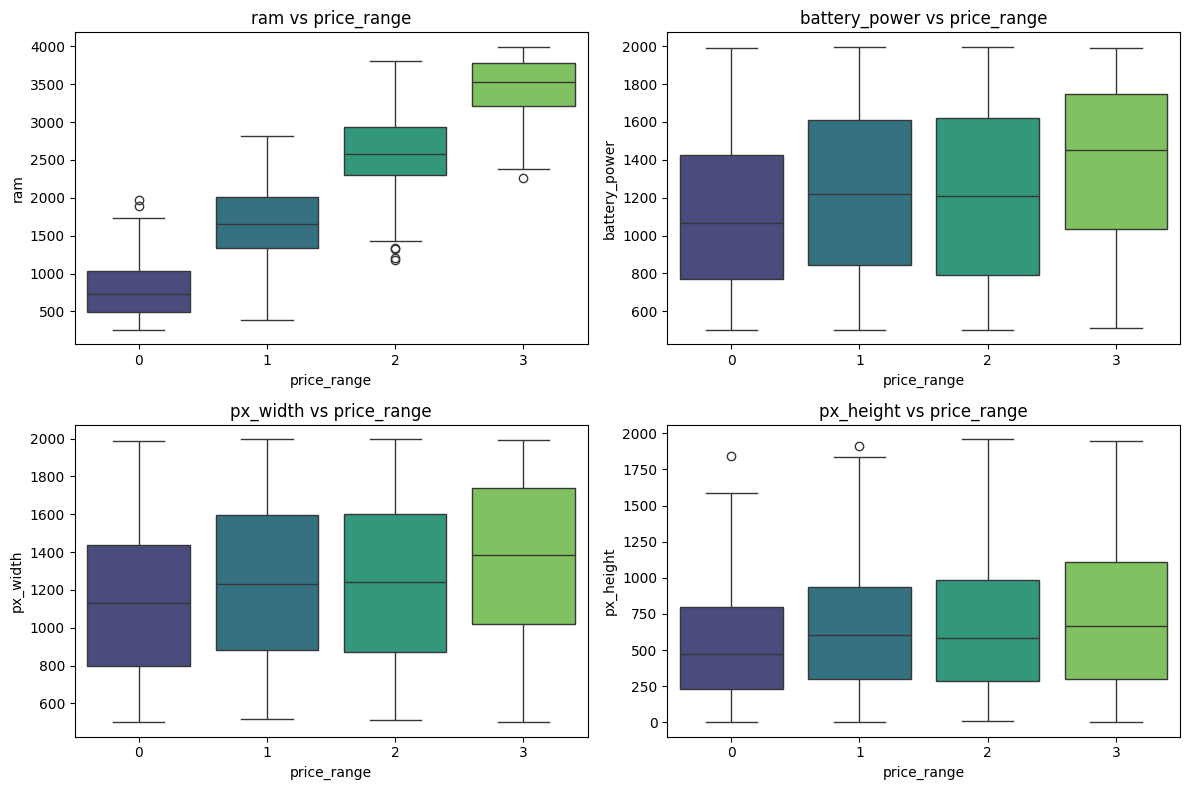

In [ ]:
# Descriptive statistics
display(X_train.describe().T)

#  Correlation matrix with target 
df_train = X_train.copy()
df_train[target] = y_train

corr = df_train.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

# Print top correlations with target
target_corr = corr[target].drop(target).sort_values(key=abs, ascending=False)
print("Top correlations with target:\n", target_corr.head(10))

# Boxplots for strongest relationships
top_features = target_corr.head(4).index.tolist()
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flat, top_features):
    sns.boxplot(data=df_train, x=target, y=feat, ax=ax, palette="viridis")
    ax.set_title(f"{feat} vs {target}")
plt.tight_layout()
plt.show()

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        75
           1       0.95      0.93      0.94        75
           2       0.95      0.92      0.93        75
           3       0.95      1.00      0.97        75

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



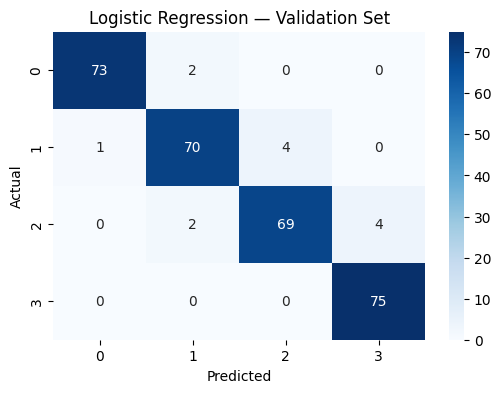

In [ ]:
# Preprocessing & Baseline Logistic Regression 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Pipeline: scale features → train logistic regression
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=SEED
    ))
])

# Fit on training set
logreg_pipeline.fit(X_train, y_train)

# Validate
y_val_pred = logreg_pipeline.predict(X_val)

# Metrics
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix heatmap
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression — Validation Set")
plt.show()

Random Forest — Validation Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        75
           1       0.85      0.84      0.85        75
           2       0.79      0.77      0.78        75
           3       0.91      0.91      0.91        75

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300



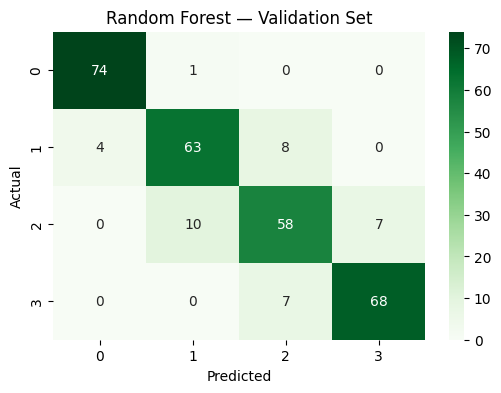


Top 10 RF Feature Importances:
 ram              0.472098
battery_power    0.077022
px_width         0.057598
px_height        0.055776
mobile_wt        0.039102
int_memory       0.037249
talk_time        0.031300
pc               0.029577
clock_speed      0.029316
sc_w             0.028626
dtype: float64


In [5]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=SEED,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
y_val_pred_rf = rf_clf.predict(X_val)

print("Random Forest — Validation Classification Report:")
print(classification_report(y_val, y_val_pred_rf))

# Confusion matrix heatmap
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest — Validation Set")
plt.show()

# Save feature importances for later
rf_importances = pd.Series(rf_clf.feature_importances_, index=FEATURES).sort_values(ascending=False)
print("\nTop 10 RF Feature Importances:\n", rf_importances.head(10))

XGBoost — Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        75
           1       0.95      0.92      0.93        75
           2       0.88      0.91      0.89        75
           3       0.96      0.92      0.94        75

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



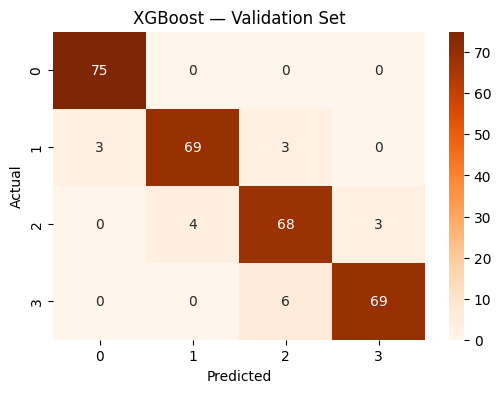

In [6]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    random_state=SEED,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist'  # GPU: use 'gpu_hist' if runtime supports it
)

xgb_clf.fit(X_train, y_train)
y_val_pred_xgb = xgb_clf.predict(X_val)

print("XGBoost — Validation Classification Report:")
print(classification_report(y_val, y_val_pred_xgb))

cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges",
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost — Validation Set")
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1360
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 20
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

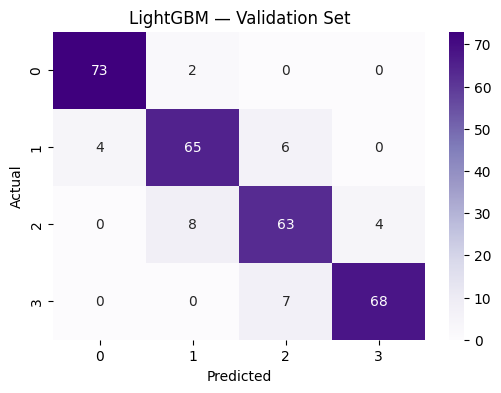

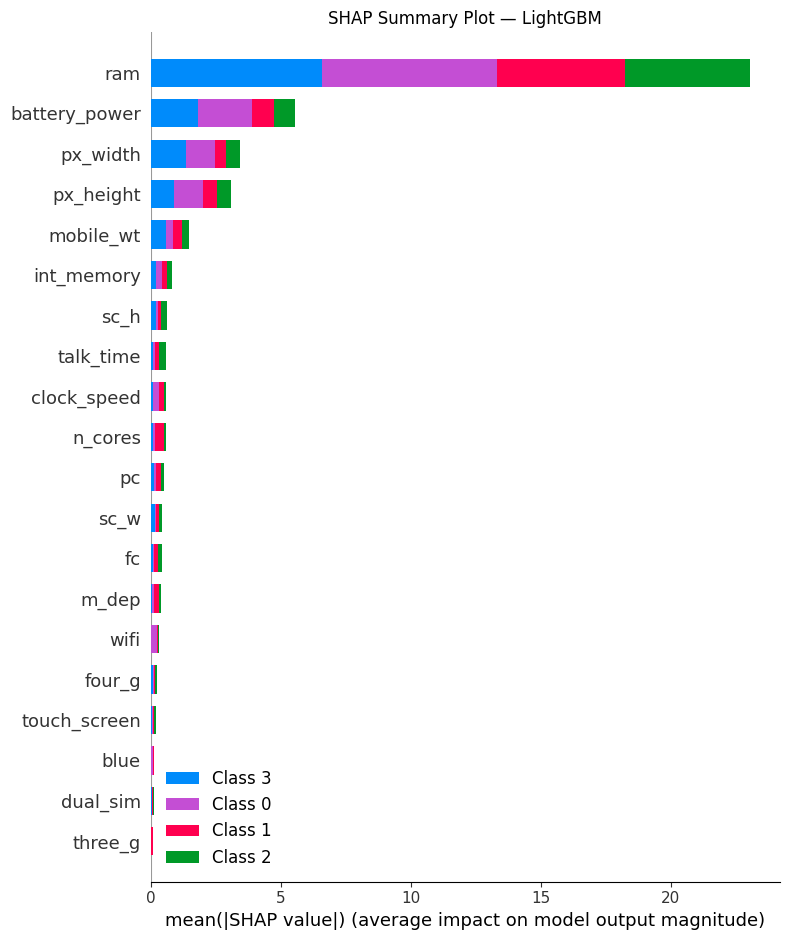

In [7]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

lgb_clf = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=4,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    n_jobs=-1
)

lgb_clf.fit(X_train, y_train)
y_val_pred_lgb = lgb_clf.predict(X_val)

print("LightGBM — Validation Classification Report:")
print(classification_report(y_val, y_val_pred_lgb))

# Confusion matrix
cm_lgb = confusion_matrix(y_val, y_val_pred_lgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Purples",
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LightGBM — Validation Set")
plt.show()

# ==== SHAP Explainability ====
import shap
explainer = shap.TreeExplainer(lgb_clf)
shap_values = explainer.shap_values(X_train)

plt.title("SHAP Summary Plot — LightGBM")
shap.summary_plot(shap_values, X_train, plot_type="bar")

,Model,Validation Accuracy
0,Logistic Regression,0.96
2,XGBoost,0.94
3,LightGBM,0.90
1,Random Forest,0.88


Final Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        75
           1       0.95      0.99      0.97        75
           2       0.96      0.97      0.97        75
           3       0.99      0.97      0.98        75

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



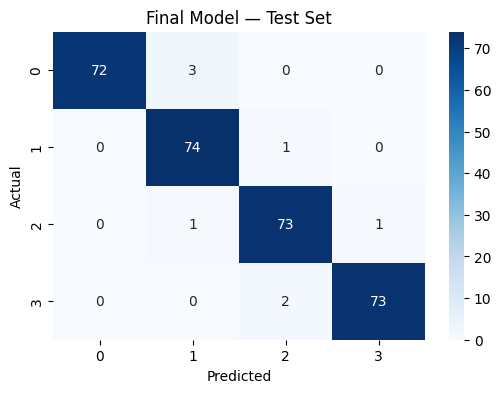

In [8]:
# Model comparison table
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Validation Accuracy': [0.96, 0.88, 0.94, 0.90]
}).sort_values(by='Validation Accuracy', ascending=False)

display(results)

# Retrain best model (Logistic Regression) on train+val, evaluate on test
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=SEED
    ))
])

best_pipeline.fit(X_train_val, y_train_val)
y_test_pred = best_pipeline.predict(X_test)

print("Final Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))

cm_final = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm_final, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Model — Test Set")
plt.show()

In [ ]:
# Feature Engineering
import numpy as np

# Copy training/validation/test sets to preserve originals
X_train_fe = X_train.copy()
X_val_fe = X_val.copy()
X_test_fe = X_test.copy()

def add_features(df):
    # Screen resolution
    df['resolution'] = df['px_height'] * df['px_width']
    # Screen area (assuming rectangular, in 'height x width' units)
    df['screen_area'] = df['sc_h'] * df['sc_w']
    # Pixels per inch (approximate PPI)
    df['ppi'] = np.sqrt(df['px_height']**2 + df['px_width']**2) / df['sc_h'].replace(0, np.nan)
    # Battery power per gram
    df['battery_per_wt'] = df['battery_power'] / df['mobile_wt']
    return df

X_train_fe = add_features(X_train_fe)
X_val_fe = add_features(X_val_fe)
X_test_fe = add_features(X_test_fe)

print(f"Original features: {X_train.shape[1]}, After engineering: {X_train_fe.shape[1]}")
X_train_fe.head()

Original features: 20, After engineering: 24


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,resolution,screen_area,ppi,battery_per_wt
1681,807,1,0.5,1,0,0,37,0.2,127,4,0,245,829,2319,5,4,4,0,0,0,203105,20,172.889097,6.354331
862,1065,1,0.5,0,0,1,14,0.7,89,2,2,188,928,3078,10,1,18,1,0,1,174464,10,94.685163,11.966292
1582,1171,1,1.7,1,2,0,19,0.3,167,7,19,248,755,263,6,5,8,0,0,0,187240,30,132.447998,7.011976
350,609,1,3.0,0,15,1,44,0.3,117,1,16,58,1253,2581,15,11,15,1,0,1,72674,165,83.622777,5.205128
1867,1193,1,2.3,0,7,0,20,1.0,158,7,13,1442,1904,1958,7,5,2,1,0,0,2745568,35,341.203751,7.550633


In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Pipeline for scaled logistic regression
logreg_pipeline_cv = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=SEED
    ))
])

# Stratified 5-Fold CV on engineered features
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scores = cross_val_score(logreg_pipeline_cv, X_train_fe, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Cross-validation accuracies: {scores}")
print(f"Mean CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validation accuracies: [0.92857143 0.95       0.95714286 0.92142857 0.93571429]
Mean CV accuracy: 0.9386 ± 0.0132


Final Model (with engineered features) — Test Set Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        75
           1       0.96      0.97      0.97        75
           2       0.95      0.96      0.95        75
           3       0.97      0.97      0.97        75

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



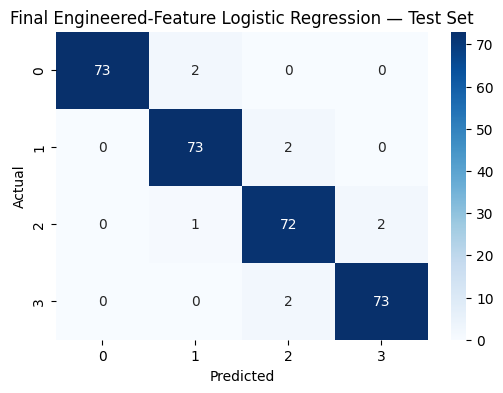

In [ ]:
# Merge train + val for final training 
X_train_val_fe = pd.concat([X_train_fe, X_val_fe], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

# Pipeline: scaling + logistic regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=SEED
    ))
])

# Train on full train+val set
final_pipeline.fit(X_train_val_fe, y_train_val)

# Test set with engineered features 
y_test_pred_final = final_pipeline.predict(X_test_fe)

# Metrics
print("Final Model (with engineered features) — Test Set Report:")
print(classification_report(y_test, y_test_pred_final))

# Confusion Matrix
cm_final = confusion_matrix(y_test, y_test_pred_final)
plt.figure(figsize=(6,4))
sns.heatmap(cm_final, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Engineered-Feature Logistic Regression — Test Set")
plt.show()